In [1]:
import seaborn as sns
import pandas as pd
import yfinance as yf
import math
import ast
import json
import statistics
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
import sys
sys.path.append('../src')
from functions import stock_selection_weight_allocation, adjust_portfolio, calculate_shares_to_buy_with_prices
warnings.filterwarnings("ignore")

In [2]:
# Load the data
data_path = '../data/final_backtesting_summary.csv'  # Update this path to your CSV file location
df = pd.read_csv(data_path, index_col=0)

In [3]:
df = df[df['Stock_Selection_Method'].isin([1,3,5,7,9,11,13,15])]

In [4]:
df.loc[df['Stock_Selection_Method'] == 3, 'Stock_Selection_Method'] = 2
df.loc[df['Stock_Selection_Method'] == 5, 'Stock_Selection_Method'] = 3
df.loc[df['Stock_Selection_Method'] == 7, 'Stock_Selection_Method'] = 4
df.loc[df['Stock_Selection_Method'] == 9, 'Stock_Selection_Method'] = 5
df.loc[df['Stock_Selection_Method'] == 11, 'Stock_Selection_Method'] = 6
df.loc[df['Stock_Selection_Method'] == 13, 'Stock_Selection_Method'] = 7
df.loc[df['Stock_Selection_Method'] == 15, 'Stock_Selection_Method'] = 8

In [5]:
df['Strategy_Combination'] = df['Stock_Selection_Method'].astype(str) + '_' + df['Weight_Allocation_Method'].astype(str) + '_' + df['Backtest_Version'].astype(str)

In [6]:
cols = ['Strategy_Combination'] + [col for col in df.columns if col != 'Strategy_Combination']
df = df[cols]

In [7]:
df

,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,Sum_Positive_Return,Sum_Negative_Return,Variance_4Y,Variance_3Y,Variance_2Y,Variance_1Y,Success_Rate,Backtest_Version,Rebalance
0,7_8_1,7,8,10.69,0.81,0.68,0.56,1.24,12,4,3.74,-0.66,0.0815,0.0521,0.0714,0.0305,0.75,1,3m
9,7_9_1,7,9,7.61,0.66,0.58,0.58,1.18,11,5,3.20,-0.61,0.0643,0.0495,0.0670,0.0324,0.69,1,3m
10,8_10_1,8,10,10.50,0.80,0.50,0.43,1.14,33,15,3.76,-1.01,0.0811,0.0296,0.0390,0.0141,0.69,1,1m
11,6_9_1,6,9,6.25,0.58,0.36,0.25,1.17,31,17,3.38,-1.21,0.0616,0.0396,0.0446,0.0333,0.65,1,1m
16,6_8_1,6,8,6.15,0.57,0.43,0.31,1.05,31,17,3.15,-1.05,0.0386,0.0240,0.0323,0.0271,0.65,1,1m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,1_10_10,1,10,4.39,0.45,0.40,0.42,0.80,11,5,2.36,-0.54,0.0408,0.0377,0.0582,0.0911,0.69,10,3m
170,1_11_10,1,11,4.35,0.44,0.42,0.40,0.74,10,6,2.31,-0.53,0.0345,0.0331,0.0486,0.0769,0.62,10,3m
171,8_3_10,8,3,5.04,0.50,0.20,0.01,0.63,26,22,4.88,-2.36,0.3413,0.0525,0.0552,0.0679,0.54,10,1m
174,6_7_10,6,7,4.50,0.46,0.45,0.33,0.23,34,14,2.48,-0.78,0.0251,0.0073,0.0086,0.0117,0.71,10,1m


In [8]:
stock_selection_methods_to_consider = []
weight_allocation_methods_to_consider = []
backtesting_versions_to_consider = []

In [9]:
max_success_rate = max(list(df['Success_Rate']))
df_max_success_rate = df[df['Success_Rate']==max_success_rate]

In [10]:
max_return_max_success_rate = max(list(df_max_success_rate['CAGR_4Y']))
df_max_return_max_success_rate = df_max_success_rate[df_max_success_rate['CAGR_4Y']==max_return_max_success_rate]

for i in range(len(df_max_return_max_success_rate)):
    stock_selection_methods_to_consider.append(df_max_return_max_success_rate['Stock_Selection_Method'].iloc[i])
    weight_allocation_methods_to_consider.append(df_max_return_max_success_rate['Weight_Allocation_Method'].iloc[i])
    backtesting_versions_to_consider.append(df_max_return_max_success_rate['Backtest_Version'].iloc[i])

print('Strategies with the maximum 4 year CAGR out of the strategies with the maximum success rate:')
df_max_return_max_success_rate

Strategies with the maximum 4 year CAGR out of the strategies with the maximum success rate:


,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,Sum_Positive_Return,Sum_Negative_Return,Variance_4Y,Variance_3Y,Variance_2Y,Variance_1Y,Success_Rate,Backtest_Version,Rebalance
149,7_7_5,7,7,9.5,0.76,0.74,0.64,1.28,14,2,3.12,-0.38,0.0452,0.0298,0.0248,0.02,0.88,5,3m
161,7_6_5,7,6,9.5,0.76,0.74,0.64,1.28,14,2,3.12,-0.38,0.0452,0.0298,0.0248,0.02,0.88,5,3m


In [11]:
min_variance_max_success_rate = min(list(df_max_success_rate['Variance_4Y']))
df_min_variance_max_success_rate = df_max_success_rate[df_max_success_rate['Variance_4Y']==min_variance_max_success_rate]

for i in range(len(df_min_variance_max_success_rate)):
    stock_selection_methods_to_consider.append(df_min_variance_max_success_rate['Stock_Selection_Method'].iloc[i])
    weight_allocation_methods_to_consider.append(df_min_variance_max_success_rate['Weight_Allocation_Method'].iloc[i])
    backtesting_versions_to_consider.append(df_min_variance_max_success_rate['Backtest_Version'].iloc[i])

print('Strategies with the minimum 4 year variance out of the strategies with the maximum success rate:')
df_min_variance_max_success_rate

Strategies with the minimum 4 year variance out of the strategies with the maximum success rate:


,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,Sum_Positive_Return,Sum_Negative_Return,Variance_4Y,Variance_3Y,Variance_2Y,Variance_1Y,Success_Rate,Backtest_Version,Rebalance
149,7_7_5,7,7,9.5,0.76,0.74,0.64,1.28,14,2,3.12,-0.38,0.0452,0.0298,0.0248,0.02,0.88,5,3m
161,7_6_5,7,6,9.5,0.76,0.74,0.64,1.28,14,2,3.12,-0.38,0.0452,0.0298,0.0248,0.02,0.88,5,3m


In [12]:
max_return = max(list(df['CAGR_4Y']))
df_max_return = df[df['CAGR_4Y']==max_return]

for i in range(len(df_max_return)):
    stock_selection_methods_to_consider.append(df_max_return['Stock_Selection_Method'].iloc[i])
    weight_allocation_methods_to_consider.append(df_max_return['Weight_Allocation_Method'].iloc[i])
    backtesting_versions_to_consider.append(df_max_return['Backtest_Version'].iloc[i])

df_max_return

,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,Sum_Positive_Return,Sum_Negative_Return,Variance_4Y,Variance_3Y,Variance_2Y,Variance_1Y,Success_Rate,Backtest_Version,Rebalance
58,4_3_10,4,3,41.83,1.54,0.92,0.4,0.94,34,14,5.19,-0.82,0.1796,0.079,0.0369,0.0262,0.71,10,1m


In [13]:
min_variance = min(list(df['Variance_4Y']))
df_min_variance = df[df['Variance_4Y']==min_variance]

for i in range(len(df_min_variance)):
    stock_selection_methods_to_consider.append(df_min_variance['Stock_Selection_Method'].iloc[i])
    weight_allocation_methods_to_consider.append(df_min_variance['Weight_Allocation_Method'].iloc[i])
    backtesting_versions_to_consider.append(df_min_variance['Backtest_Version'].iloc[i])

df_min_variance

,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,Sum_Positive_Return,Sum_Negative_Return,Variance_4Y,Variance_3Y,Variance_2Y,Variance_1Y,Success_Rate,Backtest_Version,Rebalance
36,5_6_5,5,6,2.67,0.28,0.29,0.19,0.47,12,4,1.55,-0.43,0.0152,0.0128,0.0164,0.0125,0.75,5,3m
41,5_7_5,5,7,2.67,0.28,0.29,0.19,0.47,12,4,1.55,-0.43,0.0152,0.0128,0.0164,0.0125,0.75,5,3m


In [14]:
min_success_rate = min(list(df['Success_Rate']))

df[df['Success_Rate']==min_success_rate]

,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,Sum_Positive_Return,Sum_Negative_Return,Variance_4Y,Variance_3Y,Variance_2Y,Variance_1Y,Success_Rate,Backtest_Version,Rebalance
127,6_3_8,6,3,4.09,0.42,0.36,0.16,0.25,23,25,3.51,-1.67,0.0818,0.0386,0.0371,0.0084,0.48,8,1m


In [15]:
# Calculate averages for CAGR, Variance, and Success Rate
avg_cagr_4y_by_stock_selection = df.groupby('Stock_Selection_Method')['CAGR_4Y'].mean()
avg_cagr_4y_by_weight_allocation = df.groupby('Weight_Allocation_Method')['CAGR_4Y'].mean()
avg_cagr_4y_by_rebalance = df.groupby('Rebalance')['CAGR_4Y'].mean()
avg_cagr_4y_by_backtest_version = df.groupby('Backtest_Version')['CAGR_4Y'].mean()

avg_variance_4y_by_stock_selection = df.groupby('Stock_Selection_Method')['Variance_4Y'].mean()
avg_variance_4y_by_weight_allocation = df.groupby('Weight_Allocation_Method')['Variance_4Y'].mean()
avg_variance_4y_by_rebalance = df.groupby('Rebalance')['Variance_4Y'].mean()
avg_variance_4y_by_backtest_version = df.groupby('Backtest_Version')['Variance_4Y'].mean()

success_rate_by_stock_selection = df.groupby('Stock_Selection_Method')['Success_Rate'].mean()
success_rate_by_weight_allocation = df.groupby('Weight_Allocation_Method')['Success_Rate'].mean()
success_rate_by_rebalance = df.groupby('Rebalance')['Success_Rate'].mean()
success_rate_by_backtest_version = df.groupby('Backtest_Version')['Success_Rate'].mean()

In [16]:
# Identify top and bottom categories for density plots
top_cagr_stock_method = avg_cagr_4y_by_stock_selection.nlargest(1).index.tolist()
top_cagr_weight_method = avg_cagr_4y_by_weight_allocation.nlargest(1).index.tolist()
top_version_cagr = avg_cagr_4y_by_backtest_version.nlargest(1).index.tolist()

bottom_variance_stock_method = avg_variance_4y_by_stock_selection.nsmallest(1).index.tolist()
bottom_variance_weight_method = avg_variance_4y_by_weight_allocation.nsmallest(1).index.tolist()
bottom_version_variance = avg_variance_4y_by_backtest_version.nsmallest(1).index.tolist()

top_success_rate_stock_method = success_rate_by_stock_selection.nlargest(1).index.tolist()
top_success_rate_weight_method = success_rate_by_weight_allocation.nlargest(1).index.tolist()
top_version_success_rate = success_rate_by_backtest_version.nlargest(1).index.tolist()

stock_selection_methods_to_consider += top_cagr_stock_method + bottom_variance_stock_method + top_success_rate_stock_method
weight_allocation_methods_to_consider += top_cagr_weight_method + bottom_variance_weight_method + top_success_rate_weight_method
backtesting_versions_to_consider += top_version_cagr + bottom_version_variance + top_version_success_rate

In [17]:
stock_selection_methods_to_consider = list(set(stock_selection_methods_to_consider))
weight_allocation_methods_to_consider = list(set(weight_allocation_methods_to_consider))
backtesting_versions_to_consider = list(set(backtesting_versions_to_consider))

stock_selection_methods_to_consider, weight_allocation_methods_to_consider, backtesting_versions_to_consider

([3, 4, 5, 7, 8], [1, 3, 4, 6, 7], [10, 3, 4, 5])

In [18]:
def create_bar_graphs(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    
    data = pd.DataFrame(data).reset_index()
    data.columns = [xlabel, ylabel]
    data = data.reset_index(drop=True)
    data_sorted = data.sort_values(by=ylabel, ascending=False)

    sns.barplot(x=data_sorted[xlabel], y=ylabel, data=data_sorted, palette="viridis", order=data_sorted[xlabel])
    # sns.barplot(x=xlabel, y=ylabel, data=data, palette="viridis")
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
    plt.show()

In [19]:
# Function to plot density curves with updated colors
def plot_density_curves_for_comparison(data, ids, metric, title, xlabel, ylabel, category_label):
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("dark", n_colors=len(ids))  # Use a dark color palette for clarity
    for i, id in enumerate(ids):
        subset = data[data[category_label] == id]
        sns.kdeplot(subset[metric], color=colors[i % len(colors)], label=f'{category_label} {id}', bw_adjust=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if metric.startswith('Variance'):
        plt.xlim(-0.2, 0.5)
    plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
    plt.show()

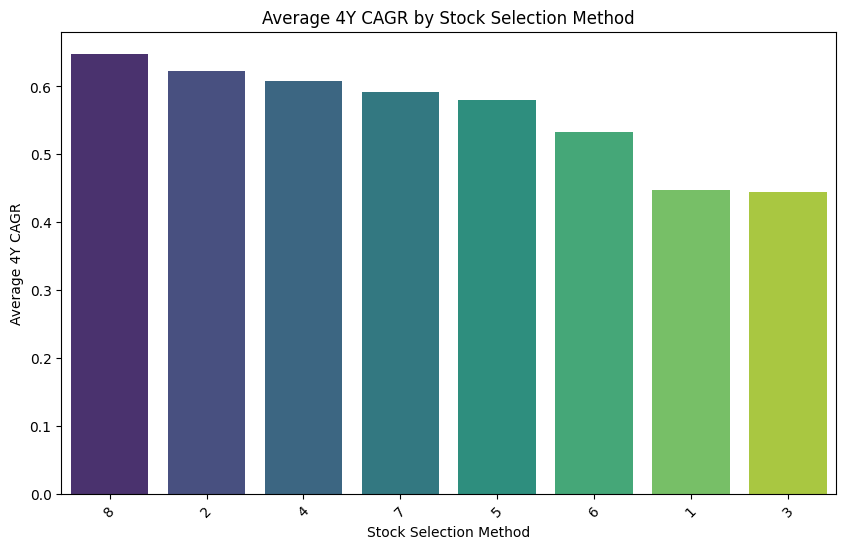

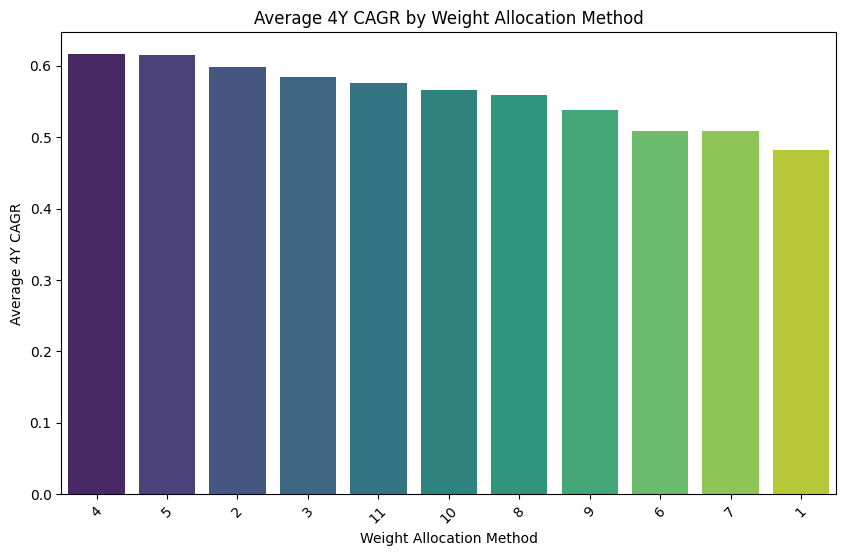

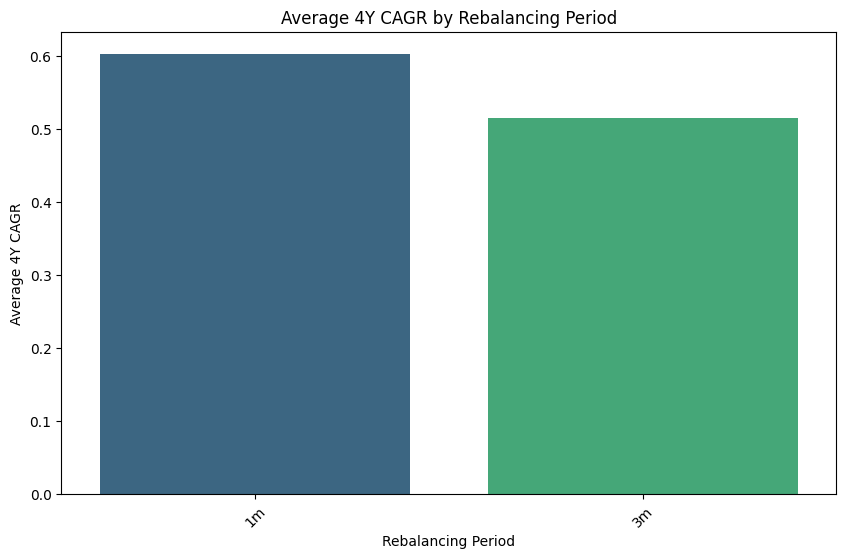

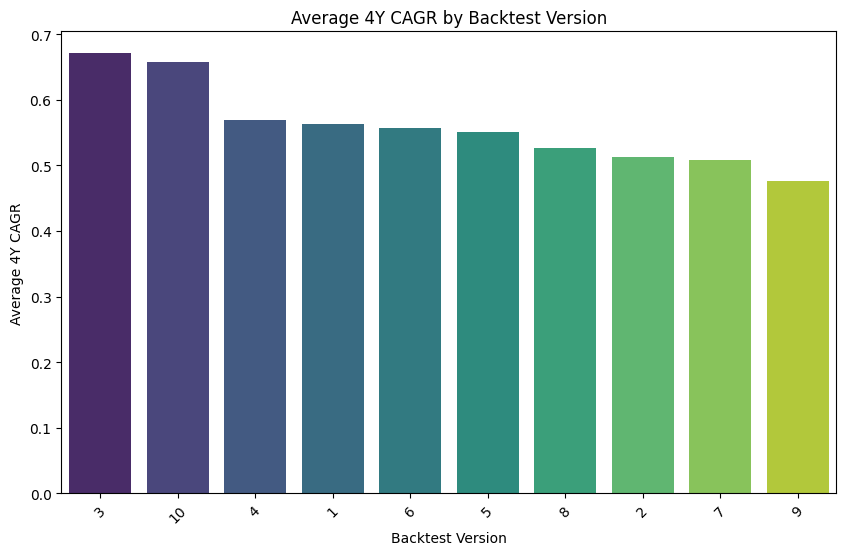

In [20]:
create_bar_graphs(avg_cagr_4y_by_stock_selection, 'Average 4Y CAGR by Stock Selection Method', 'Stock Selection Method', 'Average 4Y CAGR')
create_bar_graphs(avg_cagr_4y_by_weight_allocation, 'Average 4Y CAGR by Weight Allocation Method', 'Weight Allocation Method', 'Average 4Y CAGR')
create_bar_graphs(avg_cagr_4y_by_rebalance, 'Average 4Y CAGR by Rebalancing Period', 'Rebalancing Period', 'Average 4Y CAGR')
create_bar_graphs(avg_cagr_4y_by_backtest_version, 'Average 4Y CAGR by Backtest Version', 'Backtest Version', 'Average 4Y CAGR')

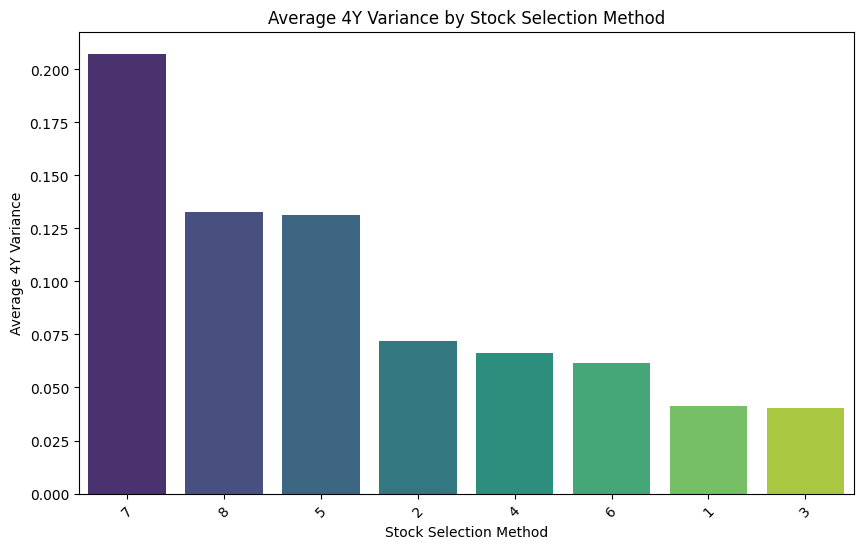

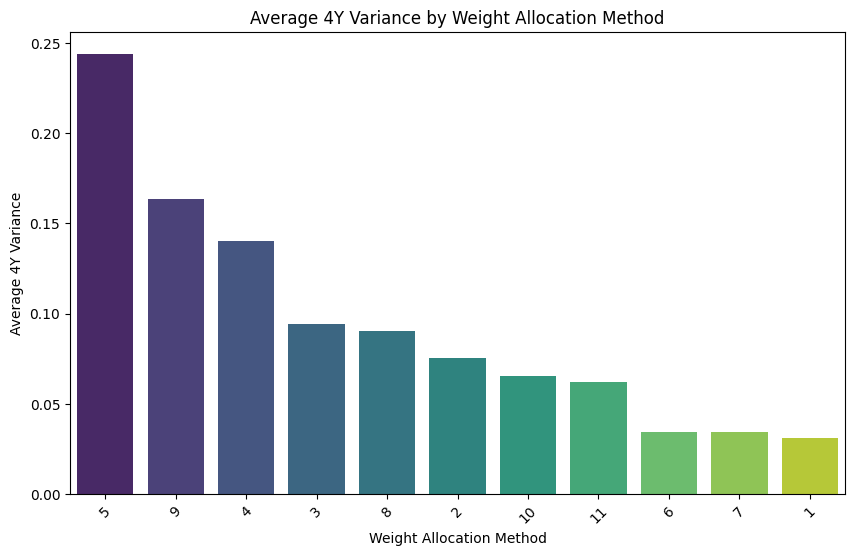

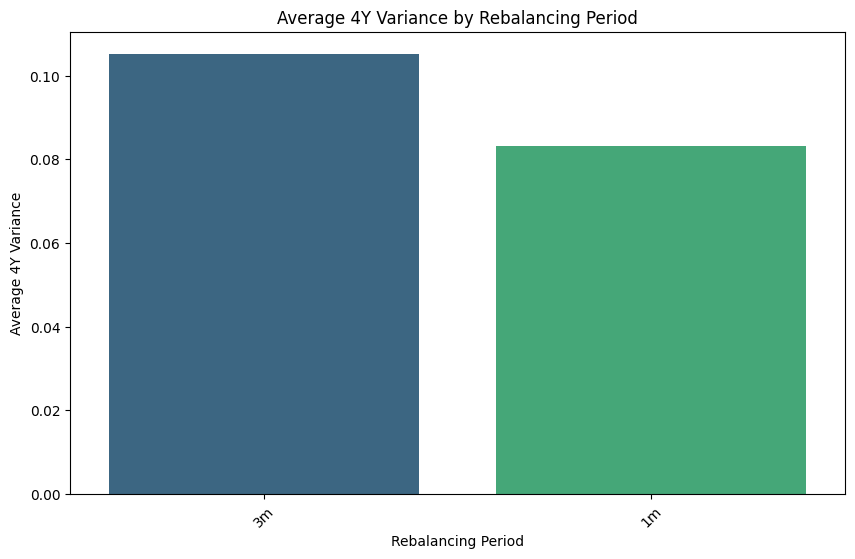

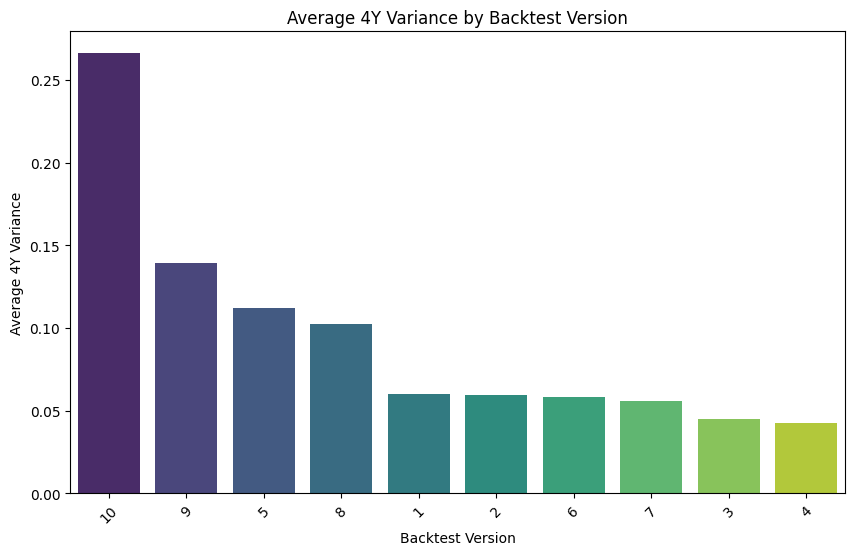

In [21]:
create_bar_graphs(avg_variance_4y_by_stock_selection, 'Average 4Y Variance by Stock Selection Method', 'Stock Selection Method', 'Average 4Y Variance')
create_bar_graphs(avg_variance_4y_by_weight_allocation, 'Average 4Y Variance by Weight Allocation Method', 'Weight Allocation Method', 'Average 4Y Variance')
create_bar_graphs(avg_variance_4y_by_rebalance, 'Average 4Y Variance by Rebalancing Period', 'Rebalancing Period', 'Average 4Y Variance')
create_bar_graphs(avg_variance_4y_by_backtest_version, 'Average 4Y Variance by Backtest Version', 'Backtest Version', 'Average 4Y Variance')

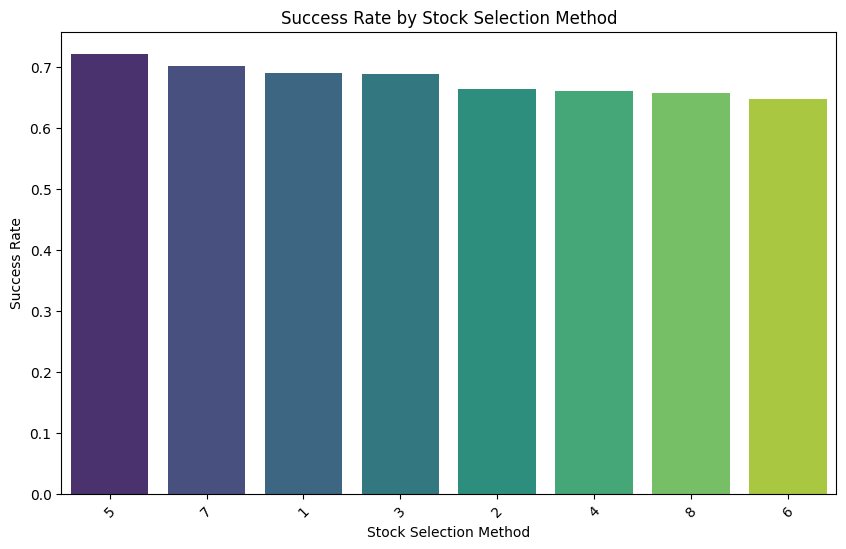

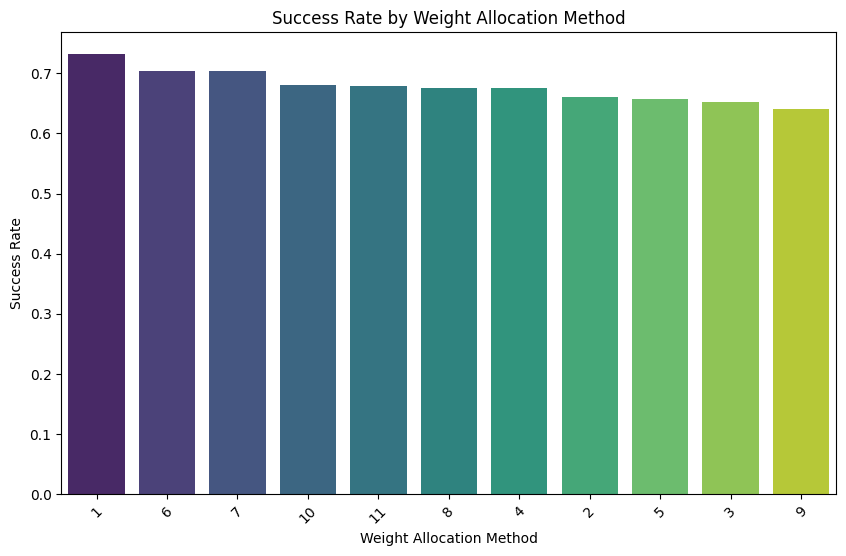

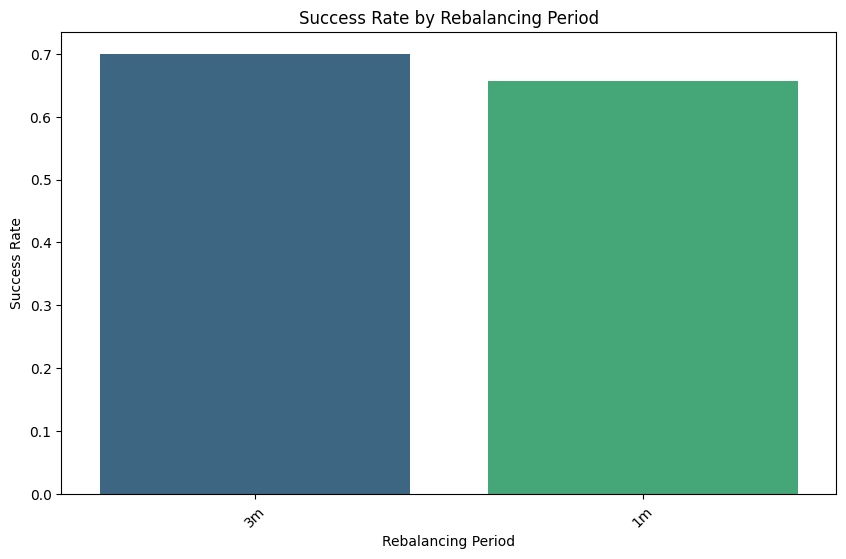

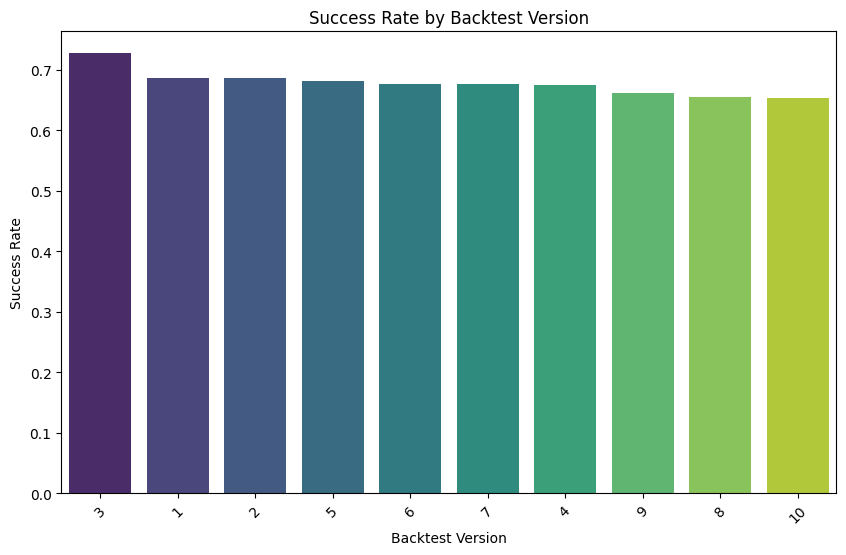

In [22]:
create_bar_graphs(success_rate_by_stock_selection, 'Success Rate by Stock Selection Method', 'Stock Selection Method', 'Success Rate')
create_bar_graphs(success_rate_by_weight_allocation, 'Success Rate by Weight Allocation Method', 'Weight Allocation Method', 'Success Rate')
create_bar_graphs(success_rate_by_rebalance, 'Success Rate by Rebalancing Period', 'Rebalancing Period', 'Success Rate')
create_bar_graphs(success_rate_by_backtest_version, 'Success Rate by Backtest Version', 'Backtest Version', 'Success Rate')

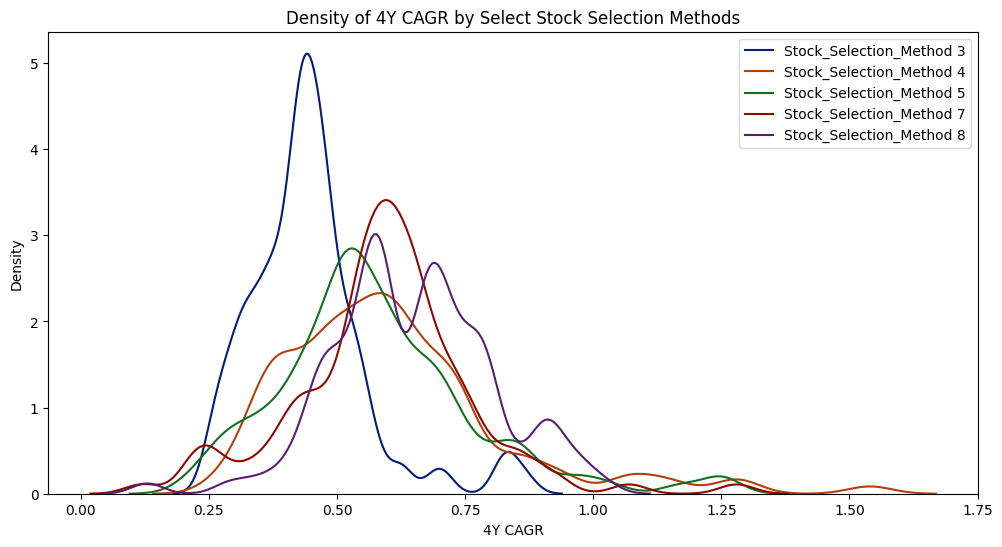

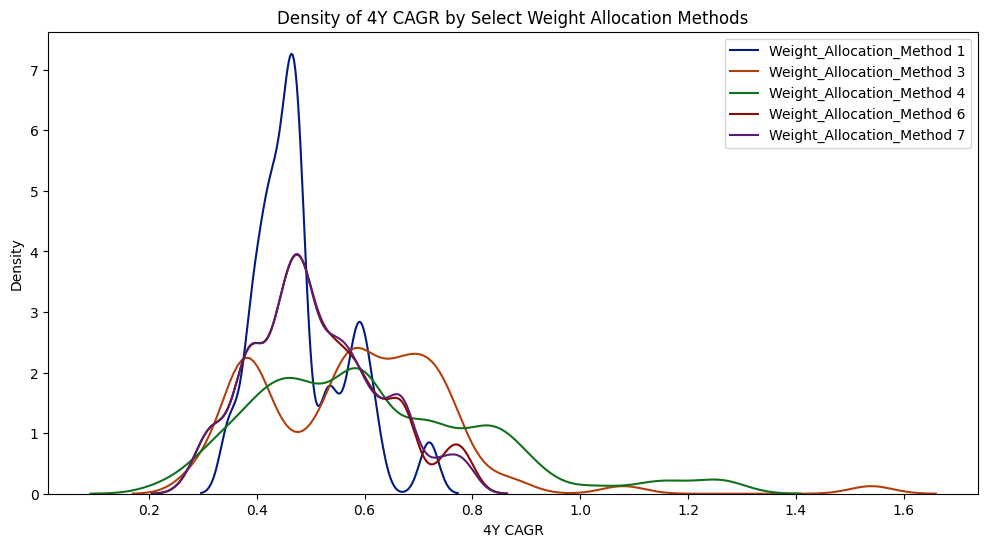

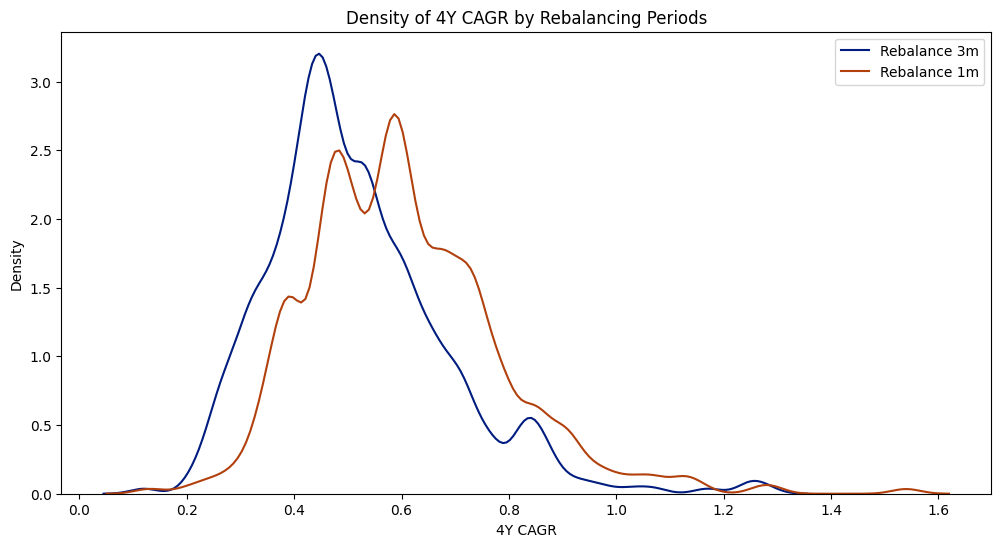

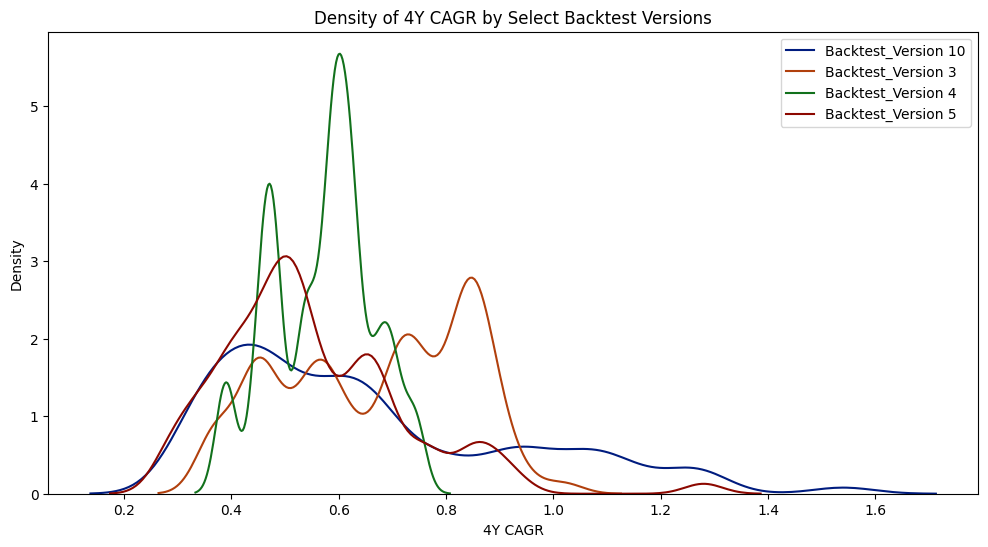

In [23]:
plot_density_curves_for_comparison(df, stock_selection_methods_to_consider, 'CAGR_4Y', 'Density of 4Y CAGR by Select Stock Selection Methods', '4Y CAGR', 'Density', 'Stock_Selection_Method')
plot_density_curves_for_comparison(df, weight_allocation_methods_to_consider, 'CAGR_4Y', 'Density of 4Y CAGR by Select Weight Allocation Methods', '4Y CAGR', 'Density', 'Weight_Allocation_Method')
plot_density_curves_for_comparison(df, df['Rebalance'].unique(), 'CAGR_4Y', 'Density of 4Y CAGR by Rebalancing Periods', '4Y CAGR', 'Density', 'Rebalance')
plot_density_curves_for_comparison(df, backtesting_versions_to_consider, 'CAGR_4Y', 'Density of 4Y CAGR by Select Backtest Versions', '4Y CAGR', 'Density', 'Backtest_Version')

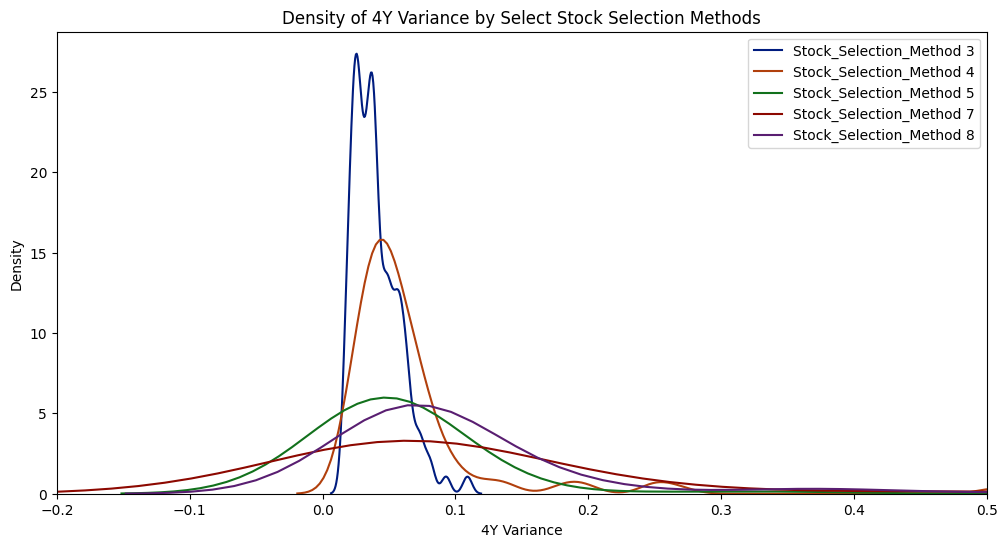

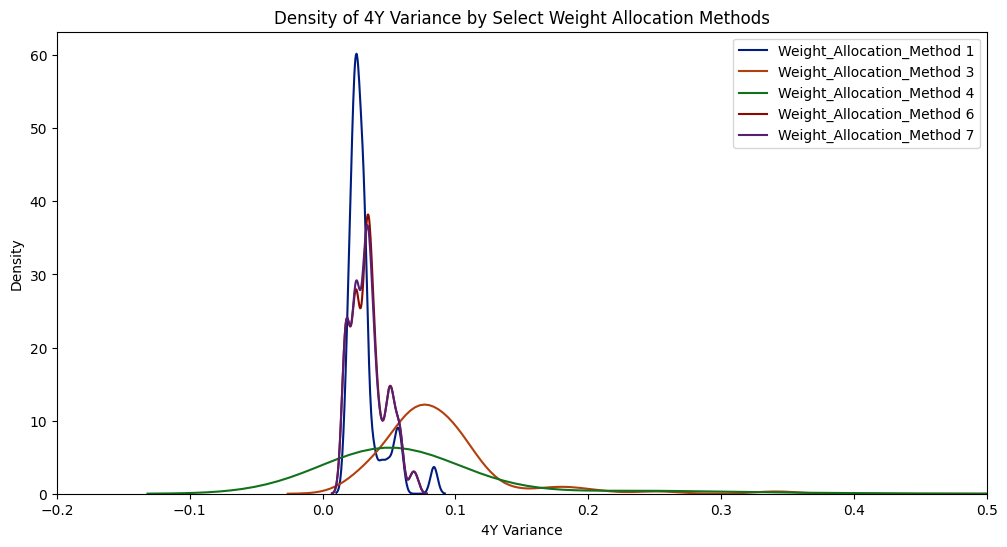

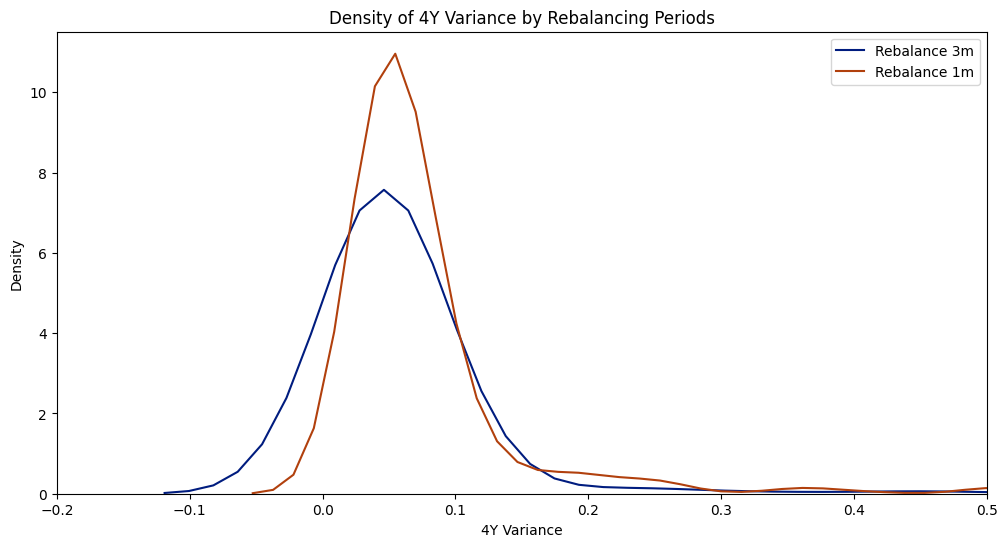

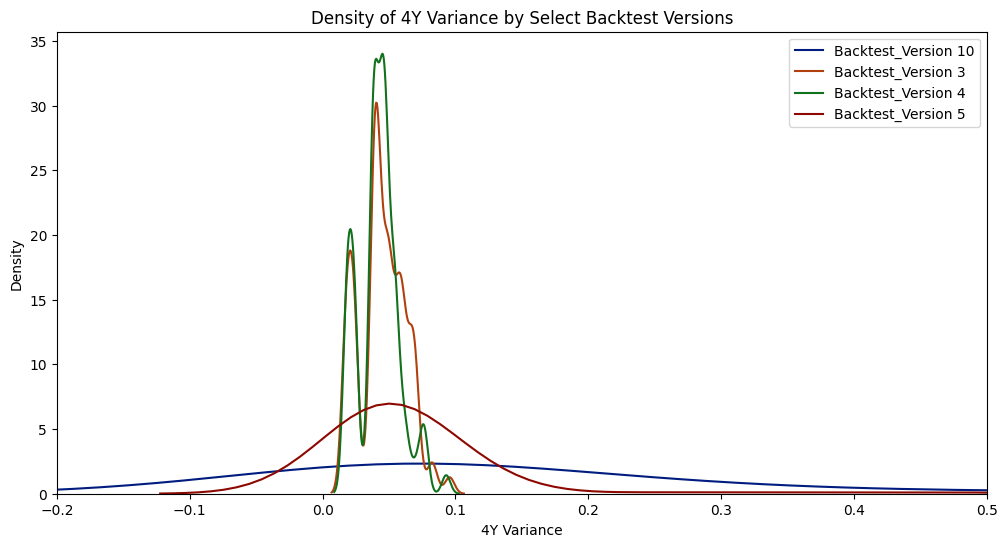

In [24]:
plot_density_curves_for_comparison(df, stock_selection_methods_to_consider, 'Variance_4Y', 'Density of 4Y Variance by Select Stock Selection Methods', '4Y Variance', 'Density', 'Stock_Selection_Method')
plot_density_curves_for_comparison(df, weight_allocation_methods_to_consider, 'Variance_4Y', 'Density of 4Y Variance by Select Weight Allocation Methods', '4Y Variance', 'Density', 'Weight_Allocation_Method')
plot_density_curves_for_comparison(df, df['Rebalance'].unique(), 'Variance_4Y', 'Density of 4Y Variance by Rebalancing Periods', '4Y Variance', 'Density', 'Rebalance')
plot_density_curves_for_comparison(df, backtesting_versions_to_consider, 'Variance_4Y', 'Density of 4Y Variance by Select Backtest Versions', '4Y Variance', 'Density', 'Backtest_Version')

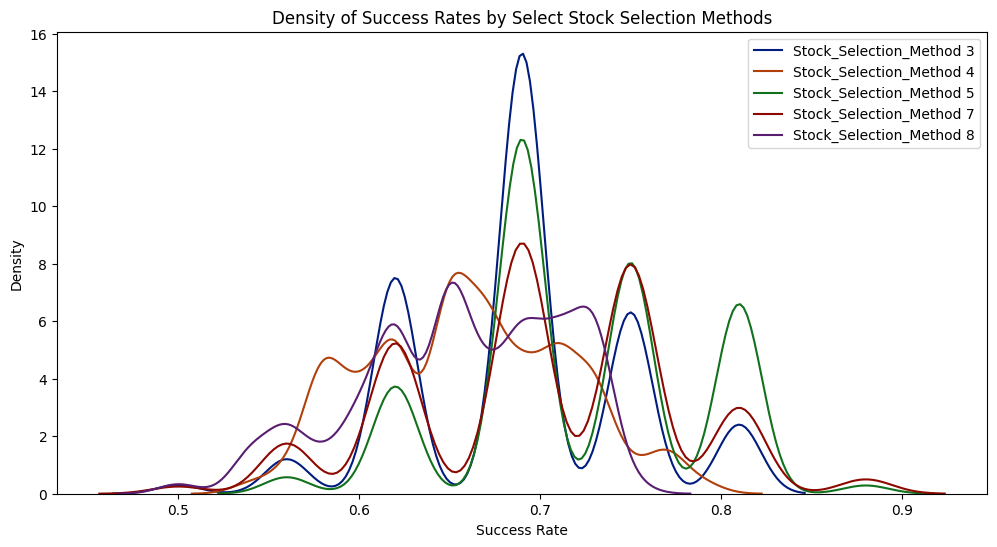

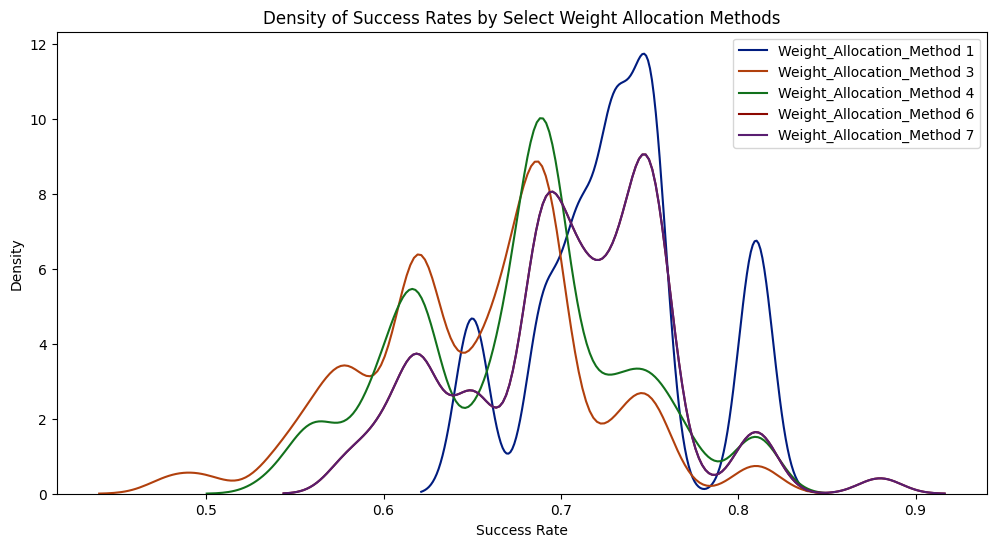

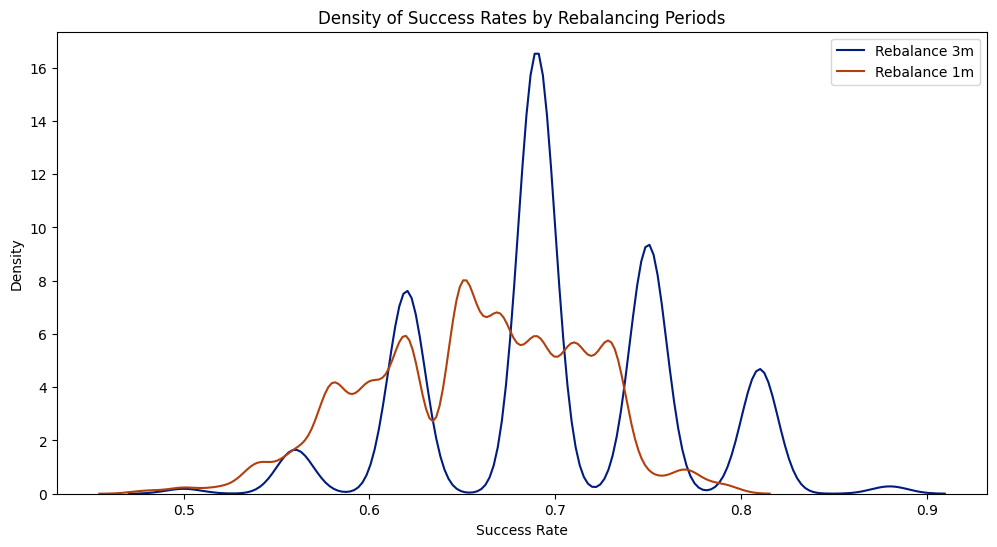

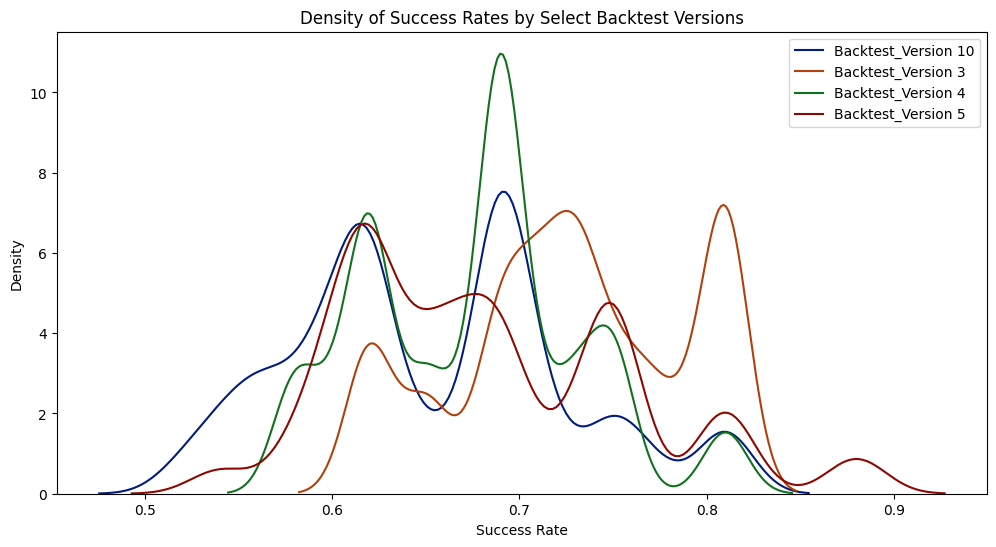

In [25]:
plot_density_curves_for_comparison(df, stock_selection_methods_to_consider, 'Success_Rate', 'Density of Success Rates by Select Stock Selection Methods', 'Success Rate', 'Density', 'Stock_Selection_Method')
plot_density_curves_for_comparison(df, weight_allocation_methods_to_consider, 'Success_Rate', 'Density of Success Rates by Select Weight Allocation Methods', 'Success Rate', 'Density', 'Weight_Allocation_Method')
plot_density_curves_for_comparison(df, df['Rebalance'].unique(), 'Success_Rate', 'Density of Success Rates by Rebalancing Periods', 'Success Rate', 'Density', 'Rebalance')
plot_density_curves_for_comparison(df, backtesting_versions_to_consider, 'Success_Rate', 'Density of Success Rates by Select Backtest Versions', 'Success Rate', 'Density', 'Backtest_Version')

In [26]:
all_stocks_df = pd.read_csv('../data/all_stock_data.csv', index_col=0)
all_stocks_df.index = pd.to_datetime(all_stocks_df.index)

In [27]:
final_symbols = list(all_stocks_df.columns)

In [28]:
govt_bond_df = pd.read_csv('../data/India 10-Year Bond Yield Historical Data.csv')
govt_bond_df = govt_bond_df[['Date','Price']]
govt_bond_df.index = govt_bond_df['Date']
govt_bond_df = govt_bond_df.drop('Date', axis=1)
govt_bond_df.index = pd.to_datetime(govt_bond_df.index)

In [29]:
def get_dates_in_range(start_date, end_date, months):
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    # Calculate end date by subtracting one month from the given end date
    end_date = datetime.strptime(end_date, '%Y-%m-%d') - relativedelta(months=months)
    
    # Generate a list of dates in the desired format
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    
    return date_list

In [30]:
start_date = '2023-10-01'
end_date = '2024-02-26'

backtesting_buying_dates_for_1m_hold = get_dates_in_range(start_date, end_date, 1)
backtesting_buying_dates_for_1q_hold = get_dates_in_range(start_date, end_date, 3)

In [31]:
market_dates_ = list(all_stocks_df.index)
market_dates = []
for date in market_dates_:
    market_dates.append(str(date)[:10])

In [32]:
backtesting_buying_dates_for_1m_hold_ = []
for date in backtesting_buying_dates_for_1m_hold:
    if date in market_dates:
        backtesting_buying_dates_for_1m_hold_.append(date)

backtesting_buying_dates_for_1m_hold = backtesting_buying_dates_for_1m_hold_[:37]

backtesting_buying_dates_for_1m_hold, len(backtesting_buying_dates_for_1m_hold)

(['2023-10-03',
  '2023-10-04',
  '2023-10-05',
  '2023-10-06',
  '2023-10-09',
  '2023-10-10',
  '2023-10-11',
  '2023-10-12',
  '2023-10-13',
  '2023-10-16',
  '2023-10-17',
  '2023-10-18',
  '2023-10-19',
  '2023-10-20',
  '2023-10-23',
  '2023-10-25',
  '2023-10-26',
  '2023-10-27',
  '2023-10-30',
  '2023-10-31',
  '2023-11-01',
  '2023-11-02',
  '2023-11-03',
  '2023-11-06',
  '2023-11-07',
  '2023-11-08',
  '2023-11-09',
  '2023-11-10',
  '2023-11-13',
  '2023-11-15',
  '2023-11-16',
  '2023-11-17',
  '2023-11-20',
  '2023-11-21',
  '2023-11-22',
  '2023-11-23',
  '2023-11-24'],
 37)

In [33]:
backtesting_buying_dates_for_1q_hold_ = []
for date in backtesting_buying_dates_for_1q_hold:
    if date in market_dates:
        backtesting_buying_dates_for_1q_hold_.append(date)

backtesting_buying_dates_for_1q_hold = backtesting_buying_dates_for_1q_hold_

backtesting_buying_dates_for_1q_hold, len(backtesting_buying_dates_for_1q_hold)

(['2023-10-03',
  '2023-10-04',
  '2023-10-05',
  '2023-10-06',
  '2023-10-09',
  '2023-10-10',
  '2023-10-11',
  '2023-10-12',
  '2023-10-13',
  '2023-10-16',
  '2023-10-17',
  '2023-10-18',
  '2023-10-19',
  '2023-10-20',
  '2023-10-23',
  '2023-10-25',
  '2023-10-26',
  '2023-10-27',
  '2023-10-30',
  '2023-10-31',
  '2023-11-01',
  '2023-11-02',
  '2023-11-03',
  '2023-11-06',
  '2023-11-07',
  '2023-11-08',
  '2023-11-09',
  '2023-11-10',
  '2023-11-13',
  '2023-11-15',
  '2023-11-16',
  '2023-11-17',
  '2023-11-20',
  '2023-11-21',
  '2023-11-22',
  '2023-11-23',
  '2023-11-24'],
 37)

In [34]:
bt_v_list = [(1,1), (1,2), (2,1), (2,2), (0.5,0.5), (1,0.5), (0.5,1), (0.25,0.25), (0.5,0.25), (0.25,0.5)]
strategies_selected = [(13,7,5),(7,3,10),(9,7,5)]

In [35]:
def save_dict_to_json(data, filename):
    """
    Saves a dictionary to a JSON file.

    Parameters:
    - data (dict): The dictionary to save.
    - filename (str): The name of the file to save the dictionary to.
    """
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

In [36]:
def load_json_to_dict(filename):
    """
    Loads JSON data from a file and returns it as a dictionary.

    Parameters:
    - filename (str): The name of the JSON file to read from.
    
    Returns:
    - dict: The dictionary containing the data read from the JSON file.
    """
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

In [37]:
try:
    strategy_performance_dict = load_json_to_dict('../data/last_4_months_results.json')
    x = len(strategy_performance_dict)
except:
    strategy_performance_dict = {}
    x = 1

# Iterate over all strategy combinations
for strategy in strategies_selected[x-1:]:

    try:
        y = len(strategy_performance_dict[str(strategy)])
        transactions = strategy_performance_dict[str(strategy)]
    except:
        y = 0
        transactions = []

    stock_selection_strategy = strategy[0]
    weight_allocation_strategy = strategy[1]
    bt_v = strategy[2]
    last_x_years = bt_v_list[bt_v-1][0]
    last_x_years_opt = bt_v_list[bt_v-1][1]

    print(stock_selection_strategy, weight_allocation_strategy, bt_v, last_x_years, last_x_years_opt)

    if stock_selection_strategy in [1,2,5,6,9,10,13,14]:
        holding_period = '1q'
    elif stock_selection_strategy in [3,4,7,8,11,12,15,16]:
        holding_period = '1m'

    dates = backtesting_buying_dates_for_1m_hold if holding_period == '1m' else backtesting_buying_dates_for_1q_hold
    
    filters = 4

    if stock_selection_strategy in [1,2,5,6,9,10,13,14]:
        holding_period = '1q'
    elif stock_selection_strategy in [3,4,7,8,11,12,15,16]:
        holding_period = '1m'

    if stock_selection_strategy in [1,3,5,7,9,11,13,15]:
        returns_type = 'SR'
    elif stock_selection_strategy in [2,4,6,8,10,12,14,16]:
        returns_type = 'LR'

    if stock_selection_strategy in [1,2,3,4]:
        max_non_positive_returns_count = 15
    elif stock_selection_strategy in [5,6,7,8]:
        max_non_positive_returns_count = 10
    elif stock_selection_strategy in [9,10,11,12]:
        max_non_positive_returns_count = None
        filters = 3
    elif stock_selection_strategy in [13,14,15,16]:
        max_non_positive_returns_count = None
        filters = 2

    for buy_date in dates[y:]:

        portfolio, sell_date, best_method = stock_selection_weight_allocation(buy_date, holding_period, returns_type, max_non_positive_returns_count, weight_allocation_strategy, all_stocks_df, govt_bond_df, filters, last_x_years, last_x_years_opt)
        
        portfolio = adjust_portfolio(portfolio)

        current_cash = 100000.00

        # Calculate the allocated cash for each stock in the portfolio
        allocated_cash = {stock: current_cash * weight for stock, weight in portfolio.items()}

        # Adjust buy_date and sell_date to the nearest next available date in all_stocks_df
        adjusted_buy_date = all_stocks_df[all_stocks_df.index >= buy_date].index[0]
        try:
            adjusted_sell_date = all_stocks_df[all_stocks_df.index >= sell_date].index[0]
        except:
            adjusted_sell_date = all_stocks_df[all_stocks_df.index <= sell_date].index[-1]

        # Get stock prices on buying and selling dates
        buy_prices = all_stocks_df.loc[adjusted_buy_date, portfolio.keys()]
        sell_prices = all_stocks_df.loc[adjusted_sell_date, portfolio.keys()]

        # Calculate the number of shares bought for each stock
        buy_quantities = {stock: allocated_cash[stock] / buy_prices[stock] for stock in portfolio.keys()}

        # Calculate the value of the portfolio at selling date
        sell_values = {stock: sell_prices[stock] * buy_quantities[stock] for stock in portfolio.keys()}
        
        current_cash = round(sum(sell_values.values()),2)
        
        # Record the transaction details
        transaction = {
            'buy_date': str(adjusted_buy_date),
            'sell_date': str(adjusted_sell_date),
            'portfolio': portfolio,
            'sell_price': current_cash
        }

        transactions.append(transaction)
        strategy_performance_dict[str(strategy)] = transactions
        save_dict_to_json(strategy_performance_dict, '../data/last_4_months_results.json')
        
        print(f'Done {buy_date}')

7 3 10 0.25 0.5
9 7 5 0.5 0.5
Done 2023-10-03
Done 2023-10-04
Done 2023-10-05
Done 2023-10-06
Done 2023-10-09
Done 2023-10-10
Done 2023-10-11
Done 2023-10-12
Done 2023-10-13
Done 2023-10-16
Done 2023-10-17
Done 2023-10-18
Done 2023-10-19
Done 2023-10-20
Done 2023-10-23
Done 2023-10-25
Done 2023-10-26
Done 2023-10-27
Done 2023-10-30
Done 2023-10-31
Done 2023-11-01
Done 2023-11-02
Done 2023-11-03
Done 2023-11-06
Done 2023-11-07
Done 2023-11-08
Done 2023-11-09
Done 2023-11-10
Done 2023-11-13
Done 2023-11-15
Done 2023-11-16
Done 2023-11-17
Done 2023-11-20
Done 2023-11-21
Done 2023-11-22
Done 2023-11-23
Done 2023-11-24


In [38]:
strategy_performance_dict = load_json_to_dict('../data/last_4_months_results.json')

In [39]:
strategy_performance_dict

{'(13, 7, 5)': [{'buy_date': '2023-10-03 00:00:00',
   'sell_date': '2024-01-03 00:00:00',
   'portfolio': {'GET&D.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'SUZLON.NS': 0.125,
    'BSE.NS': 0.125,
    'TITAGARH.NS': 0.125,
    'IRFC.NS': 0.125,
    'RESPONIND.NS': 0.125},
   'sell_price': 125930.22},
  {'buy_date': '2023-10-04 00:00:00',
   'sell_date': '2024-01-04 00:00:00',
   'portfolio': {'GET&D.NS': 0.125,
    'SUZLON.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'HBLPOWER.NS': 0.125,
    'BSE.NS': 0.125,
    'IRFC.NS': 0.125,
    'TITAGARH.NS': 0.125},
   'sell_price': 137392.35},
  {'buy_date': '2023-10-05 00:00:00',
   'sell_date': '2024-01-05 00:00:00',
   'portfolio': {'SUZLON.NS': 0.125,
    'GET&D.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'HBLPOWER.NS': 0.125,
    'TITAGARH.NS': 0.125,
    'BSE.NS': 0.125,
    'IRFC.NS': 0.125},
   'sell_price': 137018.31},
  {'buy_date': '2023-10-06 00:00:00',
   'sell_date': '2024-0

In [40]:
for strategy, result in strategy_performance_dict.items():
    print(strategy)
    count_n = 0
    count_p = 0
    for r in result:
        if r['sell_price'] <= 100000:
            count_n += 1
        else:
            count_p += 1

    print('Positie Return Count:', count_p)
    print('Negative Return Count:', count_n)
    print('*****')

(13, 7, 5)
Positie Return Count: 37
Negative Return Count: 0
*****
(7, 3, 10)
Positie Return Count: 33
Negative Return Count: 4
*****
(9, 7, 5)
Positie Return Count: 37
Negative Return Count: 0
*****


In [41]:
strategy_sell_price_dict = {}
for strategy, portfolios in strategy_performance_dict.items():
    strategy_sell_price_dict[strategy] = []
    if len(portfolios) == 65:
        for portfolio in portfolios:
            strategy_sell_price_dict[strategy].append(round((portfolio['sell_price']/100000)-1,4))
    else:
        for portfolio in portfolios:
            return_quarterly = (portfolio['sell_price']/100000)-1
            strategy_sell_price_dict[strategy].append(round(((1+return_quarterly)**(1/3))-1,4))

In [42]:
for k,v in strategy_sell_price_dict.items():
    print(k, round(sum(v)/len(v),4))

(13, 7, 5) 0.084
(7, 3, 10) 0.0312
(9, 7, 5) 0.0614


In [43]:
start_date = '2020-01-01'
end_date = '2024-02-26'

data = yf.download('^NSEI', start_date, end_date, interval="1d")
nifty50_data = data[['Adj Close']]
nifty50_data

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2020-01-01,12182.500000
2020-01-02,12282.200195
2020-01-03,12226.650391
2020-01-06,11993.049805
2020-01-07,12052.950195
...,...
2024-02-19,22122.250000
2024-02-20,22196.949219
2024-02-21,22055.050781


In [44]:
nifty_returns_1m_periods = []

for date in backtesting_buying_dates_for_1m_hold:
    buy_date = date
    sell_date = str(datetime.strptime(buy_date, '%Y-%m-%d') + relativedelta(months=1))[:10]

    adjusted_buy_date = nifty50_data[nifty50_data.index >= buy_date].index[0]
    try:
        adjusted_sell_date = nifty50_data[nifty50_data.index >= sell_date].index[0]
    except:
        adjusted_sell_date = nifty50_data[nifty50_data.index <= sell_date].index[-1]

    buy_price = nifty50_data[nifty50_data.index == adjusted_buy_date].values[0][0]
    sell_price = nifty50_data[nifty50_data.index == adjusted_sell_date].values[0][0]

    returns = (sell_price/buy_price)-1

    nifty_returns_1m_periods.append(returns)

In [45]:
nifty_returns_1q_periods = []

for date in backtesting_buying_dates_for_1q_hold:
    buy_date = date
    sell_date = str(datetime.strptime(buy_date, '%Y-%m-%d') + relativedelta(months=3))[:10]

    adjusted_buy_date = nifty50_data[nifty50_data.index >= buy_date].index[0]
    try:
        adjusted_sell_date = nifty50_data[nifty50_data.index >= sell_date].index[0]
    except:
        adjusted_sell_date = nifty50_data[nifty50_data.index <= sell_date].index[-1]

    buy_price = nifty50_data[nifty50_data.index == adjusted_buy_date].values[0][0]
    sell_price = nifty50_data[nifty50_data.index == adjusted_sell_date].values[0][0]

    returns = (sell_price/buy_price)-1

    nifty_returns_1q_periods.append(returns)

In [46]:
nifty50 = round((statistics.mean(nifty_returns_1m_periods) + (((1+statistics.mean(nifty_returns_1q_periods))**(1/3))-1))/2,4)
nifty50

0.0393

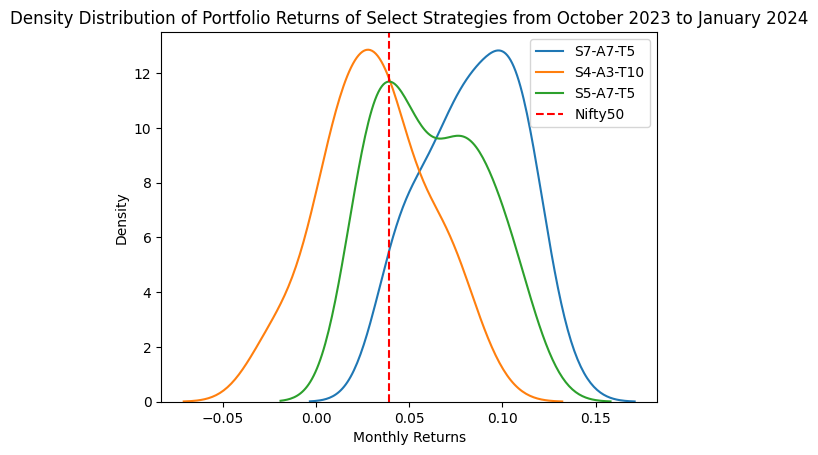

In [47]:
for strategy, returns in strategy_sell_price_dict.items():
    strategy = ast.literal_eval(strategy)
    ss = math.ceil(strategy[0]/2)
    wa = strategy[1]
    atf = strategy[2]
    label = f'S{ss}-A{wa}-T{atf}'
    sns.kdeplot(returns, label=label)

# Adding a vertical dotted line at 0.05
plt.axvline(x=nifty50, color='r', linestyle='--', label='Nifty50')

# Adding titles and labels
title = 'Density Distribution of Portfolio Returns of Select Strategies from October 2023 to January 2024'
plt.title(title)
plt.xlabel('Monthly Returns')
plt.ylabel('Density')
plt.legend()

# Save and display the plot
plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
plt.show()

In [48]:
def calculate_app_add_cost(dict1, buy, sell):
    num_stocks = len(dict1)
    total_turnover = buy+sell
    extra_cost = (16*num_stocks) + (math.ceil(total_turnover/(num_stocks*1000))*num_stocks)
    return math.ceil(extra_cost)

def add_columns_for_extra_charges(df):
    
    portfolio_list = list(df['portfolio'])
    
    selling_amount_list = list(df['investment_value'])
    buying_amount_list = [100000.00] + selling_amount_list[:-1]
    extra_cost_list = []

    for i in range(len(portfolio_list)):
        portfolio_dict = ast.literal_eval(portfolio_list[i])
        buy = buying_amount_list[i]
        sell = selling_amount_list[i]
        extra_cost = calculate_app_add_cost(portfolio_dict, buy, sell)
        extra_cost_list.append(extra_cost)
    
    return_list = []
    for i in range(len(portfolio_list)):
        returns = (selling_amount_list[i]/buying_amount_list[i])
        return_list.append(returns)

    new_selling_list = []

    for i in range(len(portfolio_list)):
        if i == 0:
            new_sell = selling_amount_list[0] - extra_cost_list[0]
            new_selling_list.append(round(new_sell,2))
        else:
            new_sell = (new_selling_list[i-1]*return_list[i]) - extra_cost_list[i]
            new_selling_list.append(round(new_sell,2))
    
    df['after_rebalancing_cost'] = new_selling_list
    
    return df

def add_columns_for_extra_charges_2(df):
    
    portfolio_list = list(df['portfolio'])
    
    selling_amount_list = list(df['investment_value_2'])
    buying_amount_list = [100000.00] + selling_amount_list[:-1]
    extra_cost_list = []

    for i in range(len(portfolio_list)):
        portfolio_dict = ast.literal_eval(portfolio_list[i])
        buy = buying_amount_list[i]
        sell = selling_amount_list[i]
        extra_cost = calculate_app_add_cost(portfolio_dict, buy, sell)
        extra_cost_list.append(extra_cost)
    
    return_list = []
    for i in range(len(portfolio_list)):
        returns = (selling_amount_list[i]/buying_amount_list[i])
        return_list.append(returns)

    new_selling_list = []

    for i in range(len(portfolio_list)):
        if i == 0:
            new_sell = selling_amount_list[0] - extra_cost_list[0]
            new_selling_list.append(round(new_sell,2))
        else:
            new_sell = (new_selling_list[i-1]*return_list[i]) - extra_cost_list[i]
            new_selling_list.append(round(new_sell,2))
    
    df['after_rebalancing_cost_2'] = new_selling_list
    
    return df

In [49]:
value_lists_list = []

for strategy in strategies_selected:
    stock_selection_method = strategy[0]
    weight_allocation_method = strategy[1]
    backtesting_version = strategy[2]
    file_path = f'../backtesting_results/version_{backtesting_version}/strategy_{stock_selection_method}_{weight_allocation_method}.csv'

    df = pd.read_csv(file_path)

    df = add_columns_for_extra_charges(df)

    value_list = [100000.00] + list(df['after rebalancing cost'])

    value_lists_list.append(value_list)

In [50]:
quarterly_dates = [datetime(year, month, 1) for year in range(2020, 2024) for month in [1, 4, 7, 10]]
formatted_quarterly_dates = [date.strftime('%Y-%m-%d') for date in quarterly_dates]

backtesting_buying_dates_for_1q_hold = formatted_quarterly_dates

len(backtesting_buying_dates_for_1q_hold)

16

In [51]:
nifty_returns_1q_periods = []

for date in backtesting_buying_dates_for_1q_hold:
    buy_date = date
    sell_date = str(datetime.strptime(buy_date, '%Y-%m-%d') + relativedelta(months=3))[:10]

    adjusted_buy_date = nifty50_data[nifty50_data.index >= buy_date].index[0]
    try:
        adjusted_sell_date = nifty50_data[nifty50_data.index >= sell_date].index[0]
    except:
        adjusted_sell_date = nifty50_data[nifty50_data.index <= sell_date].index[-1]

    buy_price = nifty50_data[nifty50_data.index == adjusted_buy_date].values[0][0]
    sell_price = nifty50_data[nifty50_data.index == adjusted_sell_date].values[0][0]

    returns = (sell_price/buy_price)-1

    nifty_returns_1q_periods.append(returns)

In [52]:
nifty_investment_values = [100000.00]

for returns in nifty_returns_1q_periods:
    nifty_investment_values.append(nifty_investment_values[-1]*(1+returns))

len(nifty_investment_values), nifty_investment_values

(17,
 [100000.0,
  67751.28097424585,
  85615.01994407963,
  93715.98764877899,
  115070.79827621588,
  122038.5767237841,
  128709.21403652779,
  143911.76508311098,
  144680.47788836443,
  145047.8080751077,
  129300.6345552021,
  138619.7382259388,
  149373.6853580956,
  142811.82664682943,
  158609.07680073872,
  160301.66222039808,
  178468.2978914426])

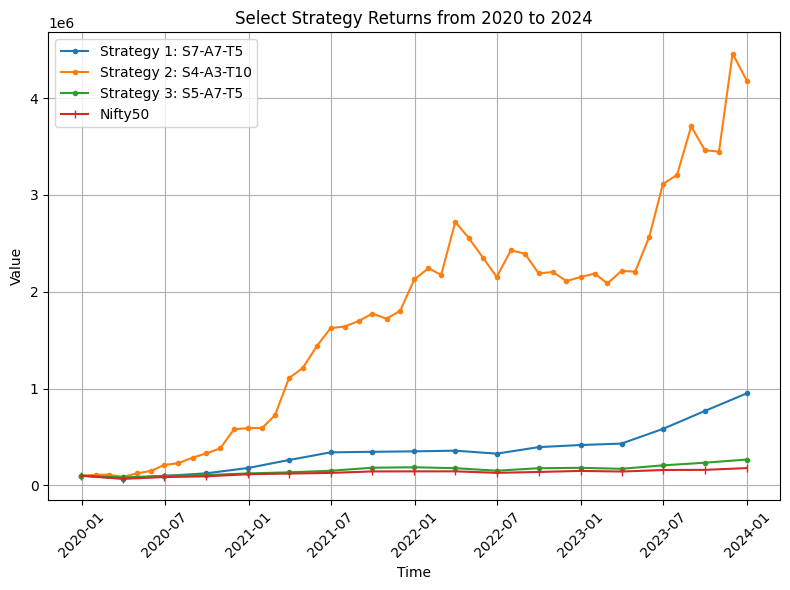

In [53]:
data_lists = value_lists_list

quarterly_dates = pd.date_range(start='2019-10-01', periods=17, freq='Q')
monthly_dates = pd.date_range(start='2019-12-01', periods=49, freq='M')

# Plotting all sub-lists on the same plot
plt.figure(figsize=(8, 6))

for data in data_lists:
    if len(data) == 17:  # If data length matches quarterly data
        plt.plot(quarterly_dates, data, marker='.', linestyle='-')
    elif len(data) == 49:  # If data length matches monthly data
        plt.plot(monthly_dates, data, marker='.', linestyle='-')

plt.plot(quarterly_dates, nifty_investment_values, marker='|', linestyle='-')

title = 'Select Strategy Returns from 2020 to 2024'
plt.title(title)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Strategy 1: S7-A7-T5', 'Strategy 2: S4-A3-T10', 'Strategy 3: S5-A7-T5', 'Nifty50'])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
plt.show()

In [54]:
strategy_performance_dict = load_json_to_dict('../data/last_4_months_results.json')

(13, 7, 5) 0.0963
(7, 3, 10) 0.0169
(9, 7, 5) 0.1033


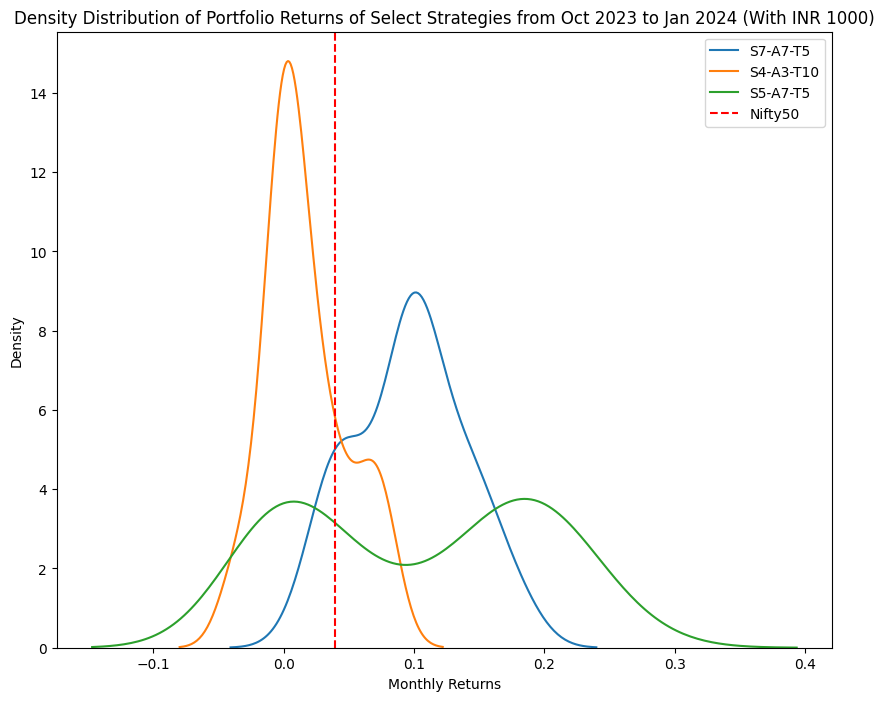

(13, 7, 5) 0.0865
(7, 3, 10) 0.0336
(9, 7, 5) 0.0629


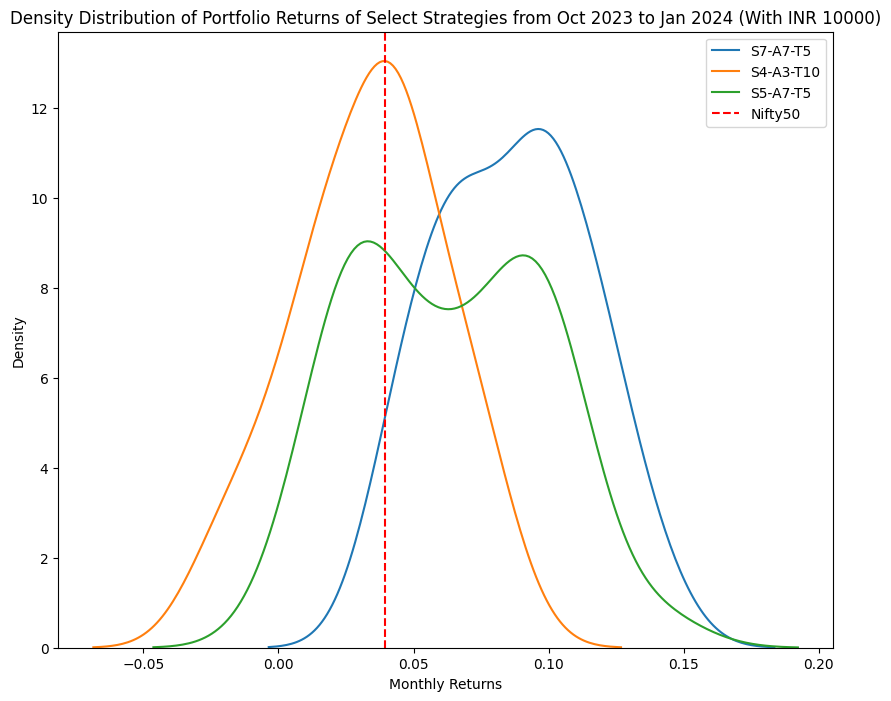

(13, 7, 5) 0.083
(7, 3, 10) 0.0311
(9, 7, 5) 0.0599


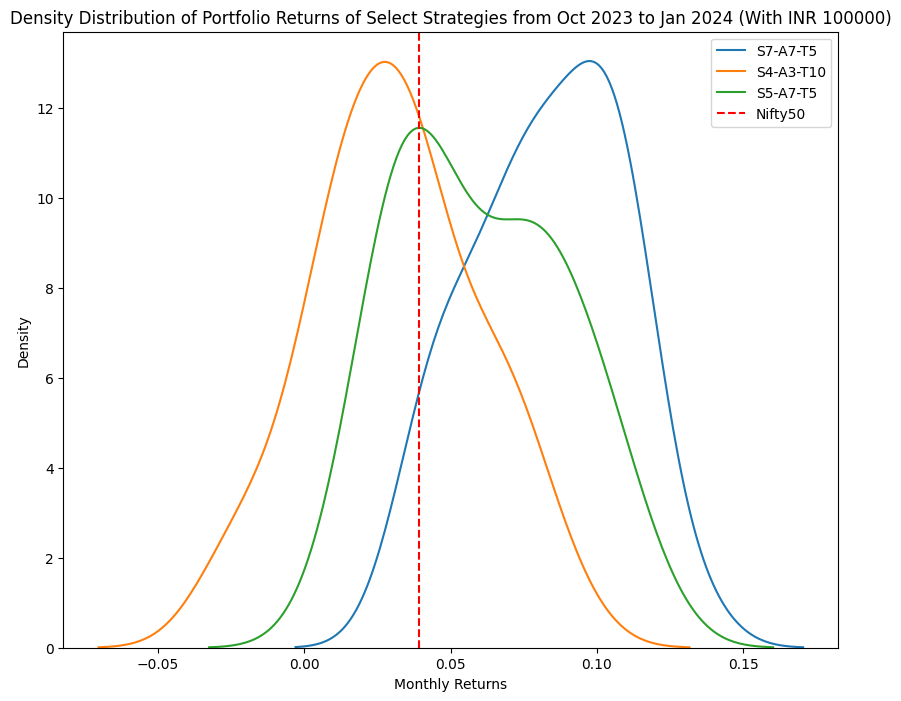

(13, 7, 5) 0.0839
(7, 3, 10) 0.0312
(9, 7, 5) 0.0612


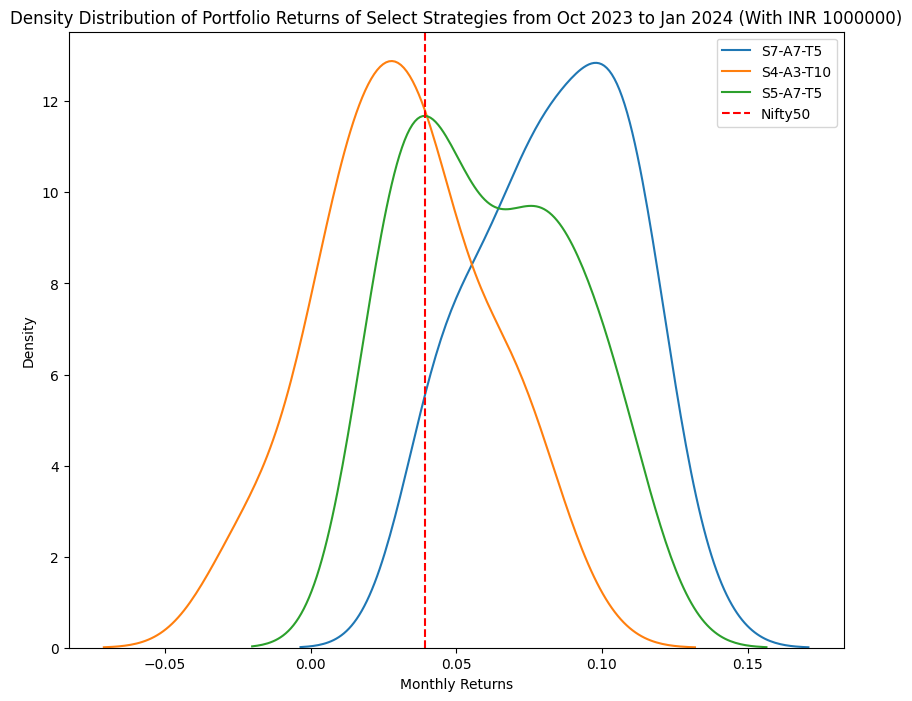

In [55]:
for amount in [1000, 10000, 100000, 1000000]:
    
    plt.figure(figsize=(10, 8))

    for strategy, results in strategy_performance_dict.items():
        for result in results:
            buying_date = result['buy_date'][:10]
            selling_date = result['sell_date'][:10]
            portfolio_weights = result['portfolio']

            adjusted_buy_date = all_stocks_df[all_stocks_df.index <= buying_date].index[-1]
            adjusted_sell_date = all_stocks_df[all_stocks_df.index <= selling_date].index[-1]
        
            final_shares, price_dict, actual_investment = calculate_shares_to_buy_with_prices(portfolio_weights, all_stocks_df, adjusted_buy_date, amount, True)
            
            profit = 0
            for stock_symbol, number_of_shares in final_shares.items():
                buy_amount = (all_stocks_df[stock_symbol].loc[adjusted_buy_date] * number_of_shares)
                sell_amount = (all_stocks_df[stock_symbol].loc[adjusted_sell_date] * number_of_shares)
                profit += sell_amount-buy_amount
            
            result['sell_price'] = amount + profit

    strategy_sell_price_dict_2 = {}
    for strategy, portfolios in strategy_performance_dict.items():
        strategy_sell_price_dict_2[strategy] = []
        if len(portfolios) == 65:
            for portfolio in portfolios:
                strategy_sell_price_dict_2[strategy].append(round((portfolio['sell_price']/amount)-1,4))
        else:
            for portfolio in portfolios:
                return_quarterly = (portfolio['sell_price']/amount)-1
                strategy_sell_price_dict_2[strategy].append(round(((1+return_quarterly)**(1/3))-1,4))

    for k,v in strategy_sell_price_dict_2.items():
        print(k, round(sum(v)/len(v),4))

    for strategy, returns in strategy_sell_price_dict_2.items():
        strategy = ast.literal_eval(strategy)
        ss = math.ceil(strategy[0]/2)
        wa = strategy[1]
        atf = strategy[2]
        label = f'S{ss}-A{wa}-T{atf}'
        sns.kdeplot(returns, label=label)

    # Adding a vertical dotted line at 0.05
    plt.axvline(x=nifty50, color='r', linestyle='--', label='Nifty50')
    # Adding titles and labels
    title = f'Density Distribution of Portfolio Returns of Select Strategies from Oct 2023 to Jan 2024 (With INR {amount})'
    plt.title(title)
    plt.xlabel('Monthly Returns')
    plt.ylabel('Density')
    plt.legend()

    # Save and display the plot
    plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
    plt.show()

In [56]:
value_lists_list_2 = []

for strategy in strategies_selected:
    
    init_invt_amt_li = []
    initial_investment = 100000

    stock_selection_method = strategy[0]
    weight_allocation_method = strategy[1]
    backtesting_version = strategy[2]
    file_path = f'../backtesting_results/version_{backtesting_version}/strategy_{stock_selection_method}_{weight_allocation_method}.csv'

    df = pd.read_csv(file_path)

    for i in range(len(df)):
        adjusted_buy_date = all_stocks_df[all_stocks_df.index <= df.iloc[i]['buy_date']].index[-1]
        adjusted_sell_date = all_stocks_df[all_stocks_df.index <= df.iloc[i]['sell_date']].index[-1]
        portfolio_weights = ast.literal_eval(df.iloc[i]['portfolio'])

        final_shares, price_dict, actual_investment = calculate_shares_to_buy_with_prices(portfolio_weights, all_stocks_df, adjusted_buy_date, initial_investment, True)

        profit = 0
        for stock_symbol, number_of_shares in final_shares.items():
            buy_amount = (all_stocks_df[stock_symbol].loc[adjusted_buy_date] * number_of_shares)
            sell_amount = (all_stocks_df[stock_symbol].loc[adjusted_sell_date] * number_of_shares)
            profit += sell_amount-buy_amount

        initial_investment += profit
        init_invt_amt_li.append(round(initial_investment,2))
    
    df['investment_value_2'] = init_invt_amt_li
    
    df = add_columns_for_extra_charges_2(df)

    value_list = [100000.00] + list(df['after_rebalancing_cost_2'])

    value_lists_list_2.append(value_list)

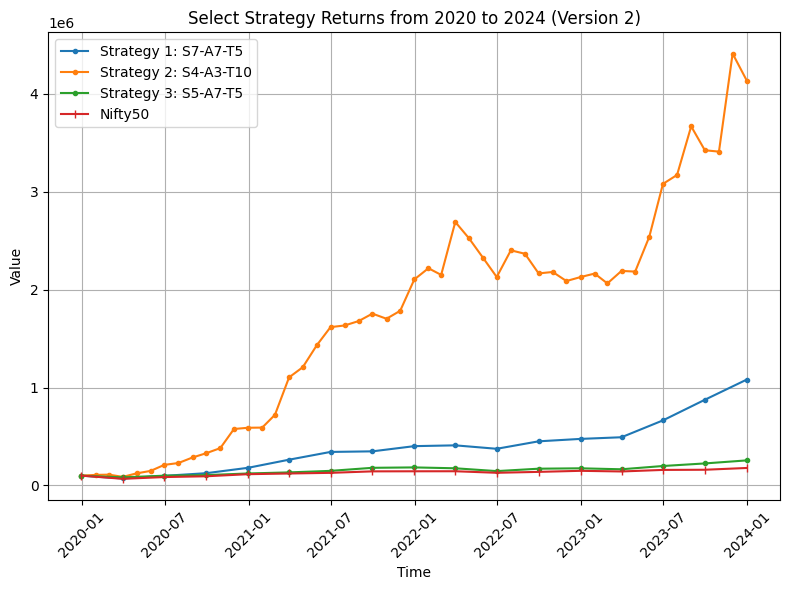

In [57]:
data_lists = value_lists_list_2

quarterly_dates = pd.date_range(start='2019-10-01', periods=17, freq='Q')
monthly_dates = pd.date_range(start='2019-12-01', periods=49, freq='M')

# Plotting all sub-lists on the same plot
plt.figure(figsize=(8, 6))

for data in data_lists:
    if len(data) == 17:  # If data length matches quarterly data
        plt.plot(quarterly_dates, data, marker='.', linestyle='-')
    elif len(data) == 49:  # If data length matches monthly data
        plt.plot(monthly_dates, data, marker='.', linestyle='-')

plt.plot(quarterly_dates, nifty_investment_values, marker='|', linestyle='-')

title = 'Select Strategy Returns from 2020 to 2024 (Version 2)'
plt.title(title)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Strategy 1: S7-A7-T5', 'Strategy 2: S4-A3-T10', 'Strategy 3: S5-A7-T5', 'Nifty50'])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
plt.show()

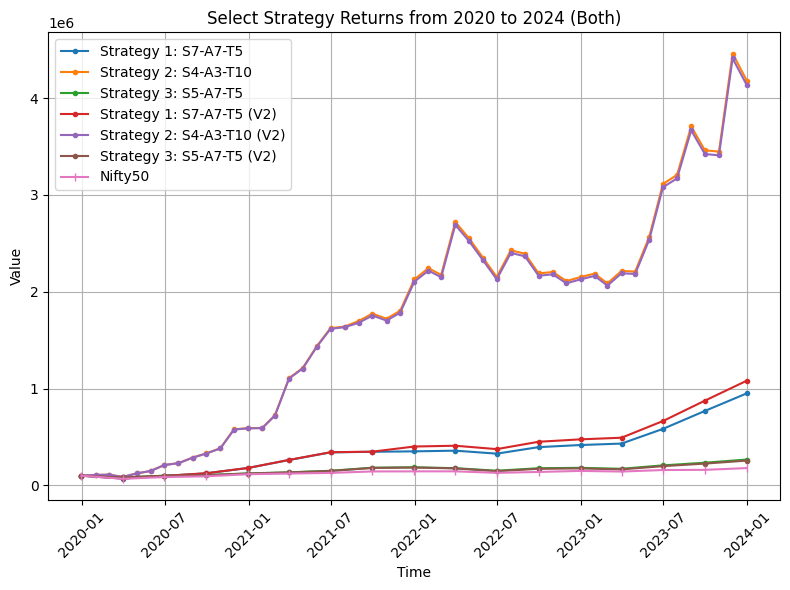

In [58]:
data_lists = value_lists_list + value_lists_list_2

quarterly_dates = pd.date_range(start='2019-10-01', periods=17, freq='Q')
monthly_dates = pd.date_range(start='2019-12-01', periods=49, freq='M')

# Plotting all sub-lists on the same plot
plt.figure(figsize=(8, 6))

for data in data_lists:
    if len(data) == 17:  # If data length matches quarterly data
        plt.plot(quarterly_dates, data, marker='.', linestyle='-')
    elif len(data) == 49:  # If data length matches monthly data
        plt.plot(monthly_dates, data, marker='.', linestyle='-')

plt.plot(quarterly_dates, nifty_investment_values, marker='|', linestyle='-')

title = 'Select Strategy Returns from 2020 to 2024 (Both)'
plt.title(title)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Strategy 1: S7-A7-T5', 'Strategy 2: S4-A3-T10', 'Strategy 3: S5-A7-T5', 'Strategy 1: S7-A7-T5 (V2)', 'Strategy 2: S4-A3-T10 (V2)', 'Strategy 3: S5-A7-T5 (V2)', 'Nifty50'])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
plt.show()

In [59]:
for list_ in value_lists_list:
    return_4y = round(list_[-1]/list_[0],2)
    annualized_return = round((return_4y**(1/4))-1,4)
    print(annualized_return)

0.7556
1.5431
0.2783


In [60]:
for list_ in value_lists_list_2:
    return_4y = round(list_[-1]/list_[0],2)
    annualized_return = round((return_4y**(1/4))-1,4)
    print(annualized_return)

0.8132
1.536
0.2649


In [61]:
nifty_investment_values

[100000.0,
 67751.28097424585,
 85615.01994407963,
 93715.98764877899,
 115070.79827621588,
 122038.5767237841,
 128709.21403652779,
 143911.76508311098,
 144680.47788836443,
 145047.8080751077,
 129300.6345552021,
 138619.7382259388,
 149373.6853580956,
 142811.82664682943,
 158609.07680073872,
 160301.66222039808,
 178468.2978914426]

In [62]:
return_4y = round(nifty_investment_values[-1]/nifty_investment_values[0],2)
annualized_return = round((return_4y**(1/4))-1,4)
annualized_return

0.1551